In [33]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
import matplotlib.pyplot as plt
%matplotlib inline

## Data

In [25]:
# DATA
import glob
# Read in cars and notcars
images = glob.glob('*vehicles/*/*')
cars = []
notcars = []
for image in images:
    if 'non' in image:
        notcars.append(image)
    else:
        cars.append(image)

## Uncomment if you need to reduce the sample size
#sample_size = 500
#cars = cars[0:sample_size]
#notcars = notcars[0:sample_size]

print(len(cars), len(notcars))

8792 8968


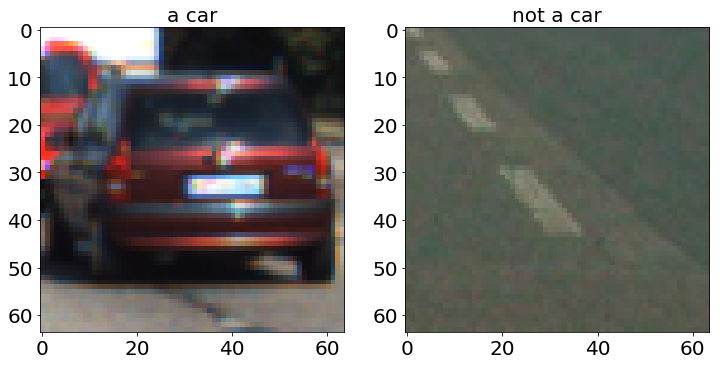

In [257]:
# Example car and non car images
font_size=20
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8))
ax1.imshow(plt.imread(cars[6600]))
ax1.set_title('a car', fontsize=font_size)
ax2.imshow(plt.imread(notcars[6600]))
ax2.set_title('not a car', fontsize=font_size)
plt.rc('xtick', labelsize=font_size) 
plt.rc('ytick', labelsize=font_size) 
plt.show()

## Extract Features

In [113]:
# convert to
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)


# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features


In [21]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        file_features = single_img_features(image, color_space, spatial_size,
                        hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel,
                        spatial_feat, hist_feat, hog_feat)
        features.append(file_features)
    # Return list of feature vectors
    return features

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

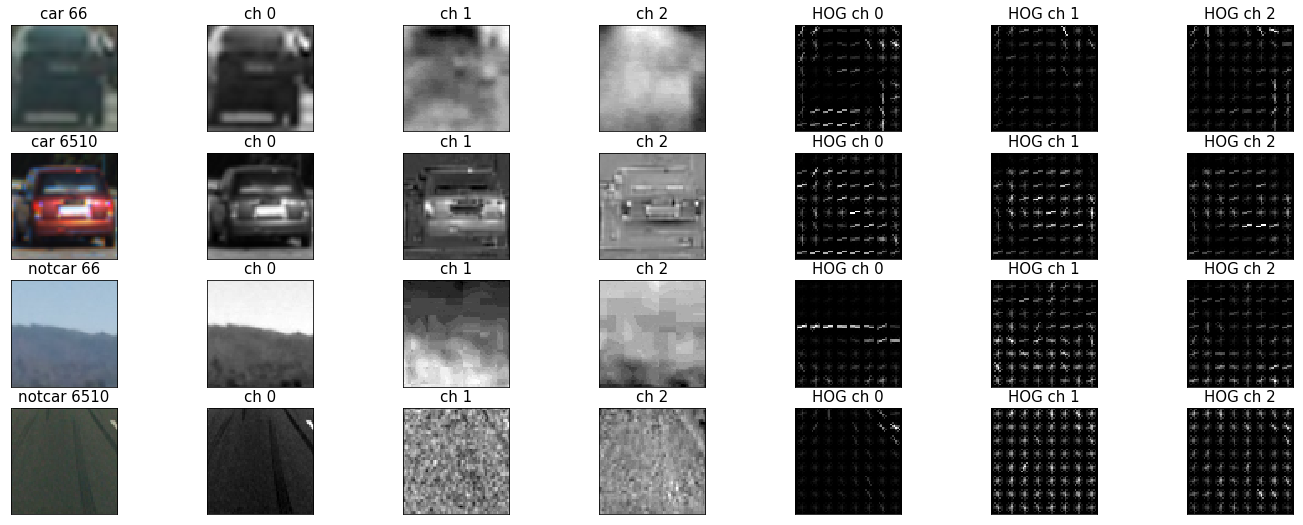

In [253]:
import random

font_size=15
f, ax = plt.subplots(4, 7,figsize=(24,9))
# f.subplots_adjust(hspace=0.2, wspace=0.05)
colorspace=cv2.COLOR_RGB2YCrCb

def make_feature_plot(label, data_set, offset=0):
    for ind, j in enumerate([66, 6510]):
        ind = ind + offset
        image = plt.imread(data_set[j])
        colorspace_image = cv2.cvtColor(image, colorspace)

        ax[ind,0].imshow(image)
        ax[ind,0].set_xticks([])
        ax[ind,0].set_yticks([])
        title = "{0} {1}".format(label, j)
        ax[ind,0].set_title(title, fontsize=font_size)

        for channel in range(3):        
            ax[ind,channel+1].imshow(colorspace_image[:,:,channel],cmap='gray')
            title = "ch {0}".format(channel)
            ax[ind,channel+1].set_title(title, fontsize=font_size)
            ax[ind,channel+1].set_xticks([])
            ax[ind,channel+1].set_yticks([])    

        for channel in range(3):
            features,hog_image = get_hog_features(colorspace_image[:,:,channel], orient, pix_per_cell, 
                                                  cell_per_block, vis=True, feature_vec=True)
            ax[ind,channel+4].imshow(hog_image,cmap='gray')
            title = "HOG ch {0}".format(channel)
            ax[ind,channel+4].set_title(title, fontsize=font_size)
            ax[ind,channel+4].set_xticks([])
            ax[ind,channel+4].set_yticks([])
            
make_feature_plot('car', cars)
make_feature_plot('notcar', notcars, 2)
        
              
plt.show()

In [115]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print('Car features: {}'.format(len(car_features[0])))

notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print('Not Car features: {}'.format(len(notcar_features[0])))
      

Car features: 6108
Not Car features: 6108


## Classifier

In [116]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import time

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108
16.2 Seconds to train SVC...
Test Accuracy of SVC =  0.9887


## Sliding Windows

In [22]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [23]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

## Window Search

In [24]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

## Testing

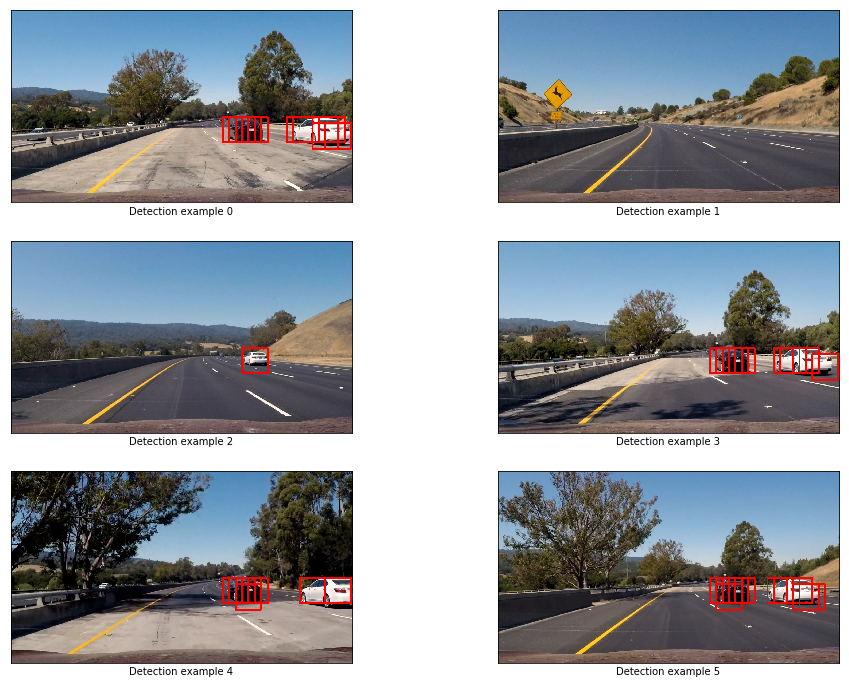

In [271]:
f, axes = plt.subplots(3, 2, figsize=(16,12))
axes = axes.flatten()

for k, image_p in enumerate(glob.glob('test_images/test*.jpg')):
    image = mpimg.imread(image_p)
    draw_image = np.copy(image)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255
    y_start_stop = [400, 640] # Min and max in y to search in slide_window()

    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(96,96), xy_overlap=(0.75, 0.75))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(255, 0, 0), thick=6)                    
    axes[k].imshow(window_img)
    xlabel = "Detection example {0}".format(k)
    axes[k].set_xlabel(xlabel)
    axes[k].set_xticks([])
    axes[k].set_yticks([]) 
plt.show()

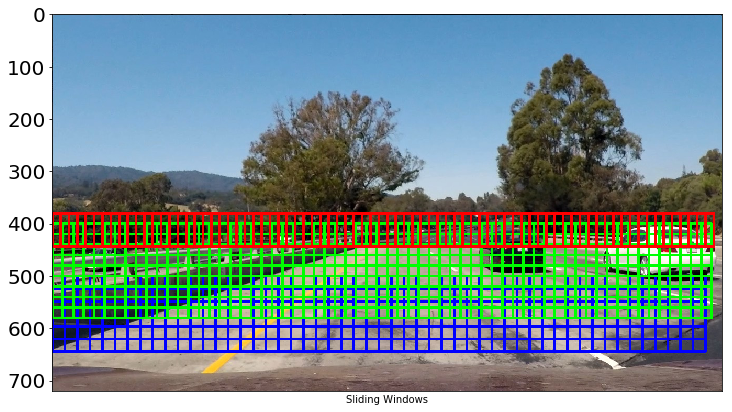

In [284]:
# Windowing for hog sub-sampling
def draw_windows(img, ystart, ystop, scale, pix_per_cell, cell_per_block, color):
    
    # draw_img = np.copy(img)
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    window_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            startx = xbox_left
            starty = ytop_draw+ystart
            endx = xbox_left+win_draw
            endy = ytop_draw+win_draw+ystart
            window_list.append(((startx, starty), (endx, endy)))
            cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),color,3) 
                
    return draw_img

scales = [1.5, 1.25, 1.0]
y_start_stops = [(500,680),(400, 600),(380,460)]
colors = [(0,0,255),(0,255,0),(255,0,0)]

f, ax = plt.subplots(1, 1, figsize=(12,8))
img = mpimg.imread('test_images/test1.jpg')
draw_img = np.copy(img)

for i, scale in enumerate(scales):
    ystart, ystop = y_start_stops[i]
    draw_img = draw_windows(draw_img, ystart, ystop, scale, pix_per_cell, cell_per_block, colors[i])

ax.imshow(draw_img)
xlabel = "Sliding Windows"
ax.set_xlabel(xlabel)
ax.set_xticks([])
#ax.set_yticks([]) 
plt.show()

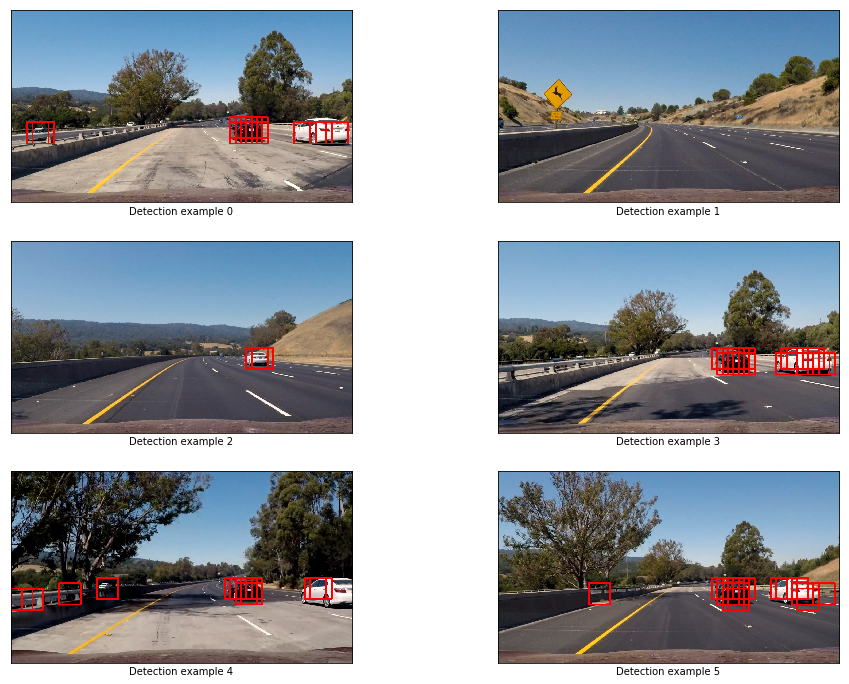

In [281]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    # draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    window_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            #hog_features = hog_feat1
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                startx = xbox_left
                starty = ytop_draw+ystart
                endx = xbox_left+win_draw
                endy = ytop_draw+win_draw+ystart
                window_list.append(((startx, starty), (endx, endy)))
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    # return draw_img
    return window_list

scales = [1.5, 1.25, 1.0]
y_start_stops = [(500,680),(400, 600),(380,460)]

f, axes = plt.subplots(3, 2, figsize=(16,12))
axes = axes.flatten()
for k, image_p in enumerate(glob.glob('test_images/test*.jpg')):
    on_windows = []
    img = mpimg.imread(image_p)
    for i, scale in enumerate(scales):
        ystart, ystop = y_start_stops[i]
        on_windows += find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    out_img = draw_boxes(img, on_windows, color=(255, 0, 0), thick=6)
    axes[k].imshow(out_img)
    xlabel = "Detection example {0}".format(k)
    axes[k].set_xlabel(xlabel)
    axes[k].set_xticks([])
    axes[k].set_yticks([]) 
plt.show()

## Tracking

In [222]:
# Heatmap
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_lists):
    for bbox_list in bbox_lists:
        # Iterate through list of bboxes
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            if box:
                box = np.array(box)
                heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [226]:
# Class to keep track of bounding boxes in successive frames of video
import collections

class CarBoxes(object):
    
    def __init__(self, num_frames=10):
        self.n = num_frames
        self.boxQ = collections.deque([], maxlen=num_frames)
        
    def add_boxes(self, boxes):
        self.boxQ.appendleft(boxes)
        
    def get_boxes(self):
        return list(self.boxQ)

In [231]:
from moviepy.editor import VideoFileClip

# get images from test video, to visualize heatmap and thresholding
clip = VideoFileClip("test_video.mp4")
img_seq = clip.write_images_sequence('test_video_images/frame%04d.jpeg')


[MoviePy] Writing frames test_video_images/frame%04d.jpeg.

38it [00:02, 18.77it/s]

[MoviePy]: Done writing frames test_video_images/frame%04d.jpeg.



## Heatmap
Example showing how heatmap with thresholding helps to detect cars in a video.

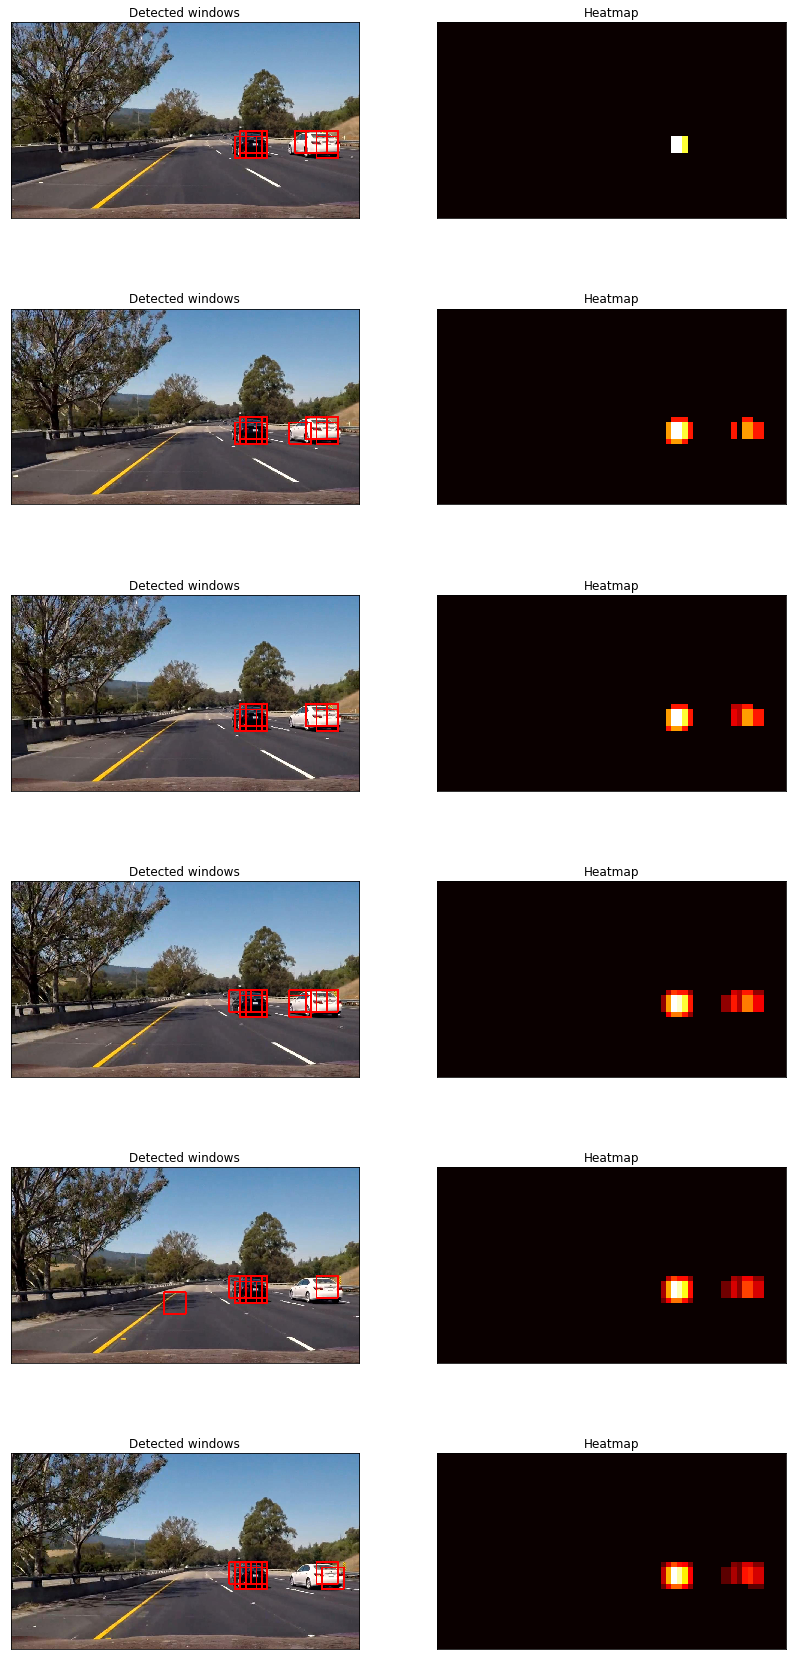

In [289]:
car_boxes = CarBoxes(6)
scales = [1.5, 1.25, 1.0]
y_start_stops = [(500,680),(400, 600),(380,460)]
f, axes = plt.subplots(6, 2, figsize=(12,24))
axes = axes.flatten()
f.tight_layout()

for k, image_f in enumerate(img_seq[10:16]):
    img = mpimg.imread(image_f)
    draw_image = np.copy(img)
    hot_windows = []

    for i, scale in enumerate(scales):
        ystart, ystop = y_start_stops[i]
        hot_windows += find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    car_boxes.add_boxes(hot_windows)
    out_img = draw_boxes(img, hot_windows, color=(255, 0, 0), thick=6)
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, car_boxes.get_boxes())
    heat  = apply_threshold(heat, 3)
    # Plot the result
    ind = 2*k
    axes[ind].imshow(out_img)
    axes[ind].set_title('Detected windows')
    axes[ind].set_xticks([])
    axes[ind].set_yticks([]) 
    
    axes[ind+1].imshow(heat, cmap='hot')
    axes[ind+1].set_title('Heatmap')
    axes[ind+1].set_xticks([])
    axes[ind+1].set_yticks([]) 

plt.show()
    

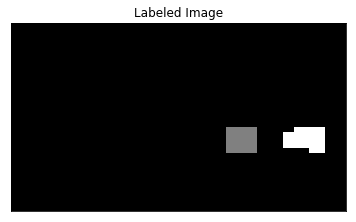

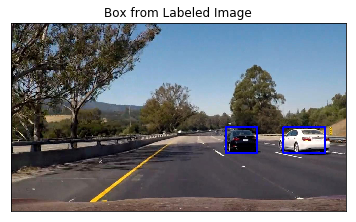

In [294]:
labels = label(heat)
plt.figure()
plt.imshow(labels[0], cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Labeled Image')
window_image = draw_labeled_bboxes(draw_image, labels)
plt.figure()
plt.imshow(window_image)
plt.xticks([])
plt.yticks([])
plt.title('Box from Labeled Image')
plt.show()

## Process Video

In [224]:
scales = [1.5, 1.25, 1.0]
y_start_stops = [(500,680),(400, 600),(380,460)]

def process_image(img):
    draw_image = np.copy(img)
    hot_windows = []

    for i, scale in enumerate(scales):
        ystart, ystop = y_start_stops[i]
        hot_windows += find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    car_boxes.add_boxes(hot_windows)
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, car_boxes.get_boxes())
    heat  = apply_threshold(heat, 15)
    labels = label(heat)
    
    window_image = draw_labeled_bboxes(draw_image, labels)
    return window_image


In [225]:
car_boxes = CarBoxes(30)
thresh = 15
clip = VideoFileClip('project_video.mp4')
out_clip = clip.fl_image(process_image) 
%time out_clip.write_videofile('project_video_out.mp4', audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [14:02<00:00,  1.47it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 13min 39s, sys: 31.7 s, total: 14min 11s
Wall time: 14min 3s
